### Fig. 00. Distribution of survived poetry books
The plot below takes raw bibliographic data as an input, reorganise it and present data as related flows of books detected in Smirdin library catalogues (19th-c.), National Library of Russia (legal deposit library before 1917, modern catalogue) and other modern collections.

#### Data load and preprocessing

In [1]:
library(tidyverse)
library(ggalluvial)
library(wesanderson)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [4]:
# load raw data

biblio <- read.csv("../data/raw_data_poetry_1830_1850.csv") %>% 
  mutate_all(~na_if(., ""))

# cleaning

biblio <- biblio %>% 
  # filter books which have several editions, while it was not always possible to detect specific editions
  filter(!str_detect(special_tag, "double")|is.na(special_tag)) %>% 
  # merge book id
  mutate(book_id = paste(id, year, poetry_prose, book_type, genre, sep = "_")) %>% 
  # select only needed columns
  select(c(book_id, smirdin_1832:Rosanov)) %>% 
  select(-(contains("price")))

glimpse(biblio)

Rows: 1,066
Columns: 18
$ book_id      <chr> "1_1834_v_sep_nar", "2_1834_v_sep_lyr", "4_1834_v_sep_lyr…
$ smirdin_1832 <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ olhin_46     <int> 5394, NA, NA, NA, NA, NA, NA, NA, 5408, NA, NA, NA, NA, 5…
$ krashen_52   <int> NA, NA, NA, 6119, 15362, 15196, 15987, 16271, 15969, NA, …
$ kymmel_89    <chr> NA, NA, NA, "1240", "567", "569", NA, NA, "1317а", "776",…
$ kymmel_xxiv  <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ MU_1838      <chr> NA, NA, NA, "да", NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ CZ_SLK       <chr> NA, NA, NA, "да", "да", NA, NA, "да", NA, NA, NA, NA, "да…
$ EE_ester     <chr> NA, NA, NA, "да", NA, NA, "да", NA, NA, NA, NA, NA, NA, N…
$ FI_NL        <chr> NA, NA, NA, "да", NA, "да", NA, NA, "да", NA, NA, NA, NA,…
$ LT_VUL       <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ PL_BUW       <chr> NA, NA, NA, "да", NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ PL_BN        <

In [5]:
# put column names as values at all non-NA cells

biblio_s <- biblio %>% 
  mutate_at(vars(smirdin_1832:Rosanov), ~ifelse(!is.na(.), "yes" , . )) %>% 
  # rename some columns
  rename(RU_NLR = RNL,
         RU_RSL = RSL,
         RU_SPU = SPbGU,
         RU_Rosanov = Rosanov)
  
t <- which(biblio_s=="yes", arr.ind = TRUE)
biblio_s[t] <- names(biblio_s)[t[,"col"]]

glimpse(biblio_s)

Rows: 1,066
Columns: 18
$ book_id      <chr> "1_1834_v_sep_nar", "2_1834_v_sep_lyr", "4_1834_v_sep_lyr…
$ smirdin_1832 <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ olhin_46     <chr> "olhin_46", NA, NA, NA, NA, NA, NA, NA, "olhin_46", NA, N…
$ krashen_52   <chr> NA, NA, NA, "krashen_52", "krashen_52", "krashen_52", "kr…
$ kymmel_89    <chr> NA, NA, NA, "kymmel_89", "kymmel_89", "kymmel_89", NA, NA…
$ kymmel_xxiv  <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ MU_1838      <chr> NA, NA, NA, "MU_1838", NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ CZ_SLK       <chr> NA, NA, NA, "CZ_SLK", "CZ_SLK", NA, NA, "CZ_SLK", NA, NA,…
$ EE_ester     <chr> NA, NA, NA, "EE_ester", NA, NA, "EE_ester", NA, NA, NA, N…
$ FI_NL        <chr> NA, NA, NA, "FI_NL", NA, "FI_NL", NA, NA, "FI_NL", NA, NA…
$ LT_VUL       <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ PL_BUW       <chr> NA, NA, NA, "PL_BUW", NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ PL_BN        <

In [6]:
# grouping old catalogues as one column var

old_cats <- biblio_s %>% 
  select(c(book_id, smirdin_1832:MU_1838)) %>% 
  pivot_longer(!book_id, 
               names_to = "name", values_to = "old_cat") %>% 
  select(-name) %>% 
  distinct()

head(old_cats)

book_id,old_cat
<chr>,<chr>
1_1834_v_sep_nar,NA
1_1834_v_sep_nar,olhin_46
2_1834_v_sep_lyr,NA
4_1834_v_sep_lyr,NA
5_1834_v_col_lyr,NA
5_1834_v_col_lyr,krashen_52


In [7]:
# grouping new catalogues (except RNL) as one column

new_cats <- biblio_s %>% 
  select(c(book_id, CZ_SLK:RU_Rosanov)) %>% 
  select(-RU_NLR) %>% 
  pivot_longer(!book_id,
               names_to = "name", values_to = "new_cat") %>% 
  select(-name) %>% 
  filter(!is.na(new_cat)) %>% 
  distinct()

head(new_cats)

book_id,old_cat
<chr>,<chr>
1_1834_v_sep_nar,NA
1_1834_v_sep_nar,olhin_46
2_1834_v_sep_lyr,NA
4_1834_v_sep_lyr,NA
5_1834_v_col_lyr,NA
5_1834_v_col_lyr,krashen_52


book_id,new_cat
<chr>,<chr>
1_1834_v_sep_nar,RU_RSL
1_1834_v_sep_nar,RU_Rosanov
5_1834_v_col_lyr,CZ_SLK
5_1834_v_col_lyr,EE_ester
5_1834_v_col_lyr,FI_NL
5_1834_v_col_lyr,PL_BUW


In [8]:
# additional groups for filling colour column ("survival")

# books found only in NLR
only_rnl <- biblio_s %>% 
  select(book_id, RU_NLR) %>% 
  filter(!is.na(RU_NLR)) %>% 
  anti_join(new_cats, by = "book_id") %>% 
  mutate(survived = "Only in NLR") %>% 
  select(book_id, survived)

# separate table for books not found in any catalogues
lost <- biblio_s %>% 
  anti_join(new_cats, by = "book_id") %>% 
  anti_join(only_rnl, by = "book_id") %>% 
  mutate(survived = "Lost") %>% 
  select(book_id, survived)

# books not found in RNL but elsewhere
only_outside <- biblio_s %>% 
  select(book_id, RU_NLR) %>% 
  filter(is.na(RU_NLR)) %>% 
  inner_join(new_cats, by = "book_id") %>% 
  mutate(survived = "Only outside NLR") %>% 
  select(book_id, survived)

In [10]:
# combine tables & tags
biblio_l <- biblio_s %>% 
  select(book_id, RU_NLR) %>% 
  left_join(old_cats, by = "book_id") %>% 
  left_join(new_cats, by = "book_id") %>% 
  left_join(only_rnl, by = "book_id") %>% 
  left_join(only_outside, by = "book_id") %>% 
  left_join(lost, by = "book_id") %>% 
  mutate(across(everything(), as.character)) %>% 
  mutate_all(funs(replace_na(., "NA"))) %>% 
  mutate(survived = paste(survived.x, survived.y, survived, sep = "_")) %>% 
  mutate(survived.x = str_remove_all(survived, "NA_|_NA")) %>% 
  mutate(survived = ifelse(survived.x == "NA", 
                           "In NLR & outside",
                           survived.x)) %>% 
  select(-c(survived.x, survived.y)) %>% 
  group_by(across(c(-book_id))) %>% 
  count(sort = T) %>% 
  ungroup()

head(biblio_l)

RU_NLR,old_cat,new_cat,survived,n
<chr>,<chr>,<chr>,<chr>,<int>
RU_NLR,NA,RU_RSL,In NLR & outside,520
RU_NLR,NA,NA,Only in NLR,318
RU_NLR,NA,RU_Rosanov,In NLR & outside,229
RU_NLR,krashen_52,RU_RSL,In NLR & outside,226
RU_NLR,NA,FI_NL,In NLR & outside,210
RU_NLR,olhin_46,RU_RSL,In NLR & outside,210


#### Alluvial plot

In [11]:
bib_l <- biblio_l %>% 
  # filter books which are known from untrusted sources
  filter(!(old_cat == "NA" & RU_NLR == "NA" & new_cat == "NA")) %>% 
  select(old_cat, RU_NLR, new_cat, survived, n) %>% 
  # change "NA" to different categories
  mutate(old_cat = str_replace_all(old_cat, "NA", "0 Not found"),
         RU_NLR = str_replace_all(RU_NLR, "NA", "Not found NLR"),
         new_cat = str_replace_all(new_cat, "NA", "0 Not available"))
  

# turn data to alluvium long type
biblio_al <- to_lodes_form(bib_l, 
                           key = "Catalogues", 
                           axes = 1:3)
head(biblio_al)

survived,n,alluvium,Catalogues,stratum
<chr>,<int>,<int>,<fct>,<fct>
In NLR & outside,520,1,old_cat,0 Not found
Only in NLR,318,2,old_cat,0 Not found
In NLR & outside,229,3,old_cat,0 Not found
In NLR & outside,226,4,old_cat,krashen_52
In NLR & outside,210,5,old_cat,0 Not found
In NLR & outside,210,6,old_cat,olhin_46


Warning message:
“`spread_()` was deprecated in tidyr 1.2.0.
ℹ Please use `spread()` instead.
ℹ The deprecated feature was likely used in the ggalluvial package.
  Please report the issue at
  <https://github.com/corybrunson/ggalluvial/issues>.”
Warning message:
“The `.dots` argument of `group_by()` is deprecated as of dplyr 1.0.0.
ℹ The deprecated feature was likely used in the dplyr package.
  Please report the issue at <https://github.com/tidyverse/dplyr/issues>.”


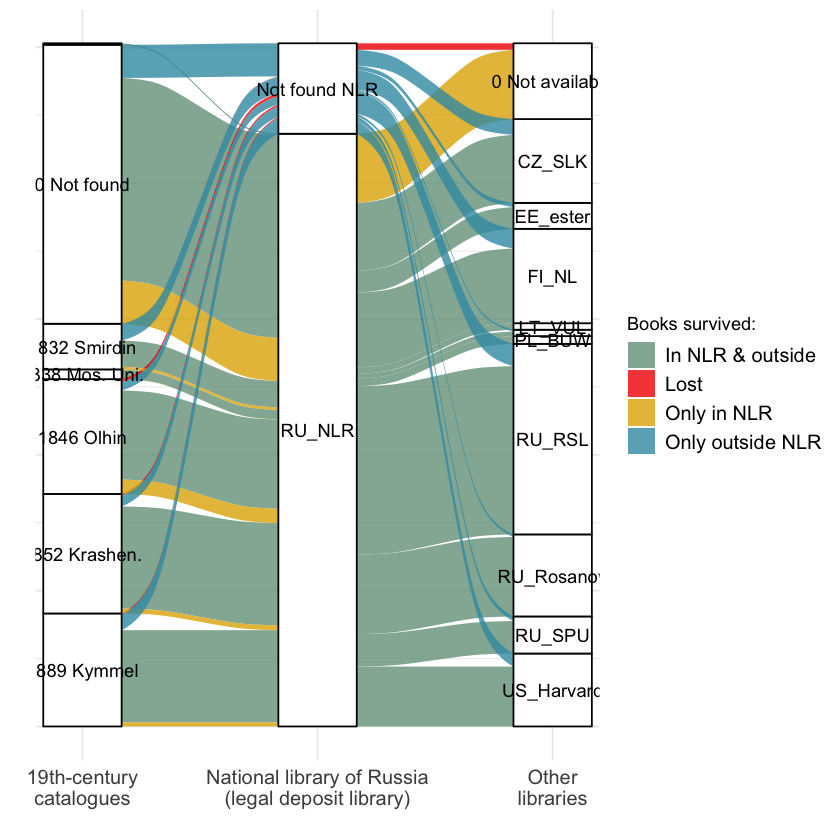

In [12]:
# Plot

biblio_al %>% 
  # rename stratum for prettier lables
  mutate(stratum = str_replace_all(stratum, "olhin_46", "1846 Olhin")) %>% 
  mutate(stratum = str_replace_all(stratum, "krashen_52", "1852 Krashen.")) %>% 
  mutate(stratum = str_replace_all(stratum, "kymmel_89", "1889 Kymmel")) %>% 
  mutate(stratum = str_replace_all(stratum, "smirdin_1832", "1832 Smirdin")) %>% 
  mutate(stratum = str_replace_all(stratum, "MU_1838", "1838 Mos. Uni.")) %>% 
  mutate(stratum = str_replace_all(stratum, "kymmel_xxiv", "")) %>% 
  ggplot(aes(x = Catalogues,
             stratum = stratum,
             alluvium = alluvium,
             y = n,
             label = stratum)) +
  geom_flow(aes(fill = survived), 
            alpha = 0.8) +
  geom_stratum() + 
  geom_text(stat = "stratum", check_overlap = T) + 
  labs(x = "", y = "", fill = "Books survived:") + 
  theme_minimal() + 
  scale_fill_manual(values = c(
    wes_palette("Royal2")[5], wes_palette("Zissou1")[5], 
    wes_palette("Zissou1")[4], wes_palette("Zissou1")[1] 
    )) + 
  scale_x_discrete(labels = c("19th-century\ncatalogues", 
                              "National library of Russia\n(legal deposit library)", 
                              "Other\nlibraries"),
                   expand = c(0.1,0)) + 
  theme(axis.text.y = element_blank(),
        legend.text = element_text(size = 12),
        #legend.position = "bottom",
        axis.text.x = element_text(size = 12))
